Checking Soil Types dataset: /kaggle/input/soil-types/Soil types
Contents: ['Yellow Soil', 'Laterite Soil', 'Black Soil', 'Peat Soil', 'Cinder Soil']
Checking Soil_Data_V3 dataset: /kaggle/input/soil-data-v3/Soil_Data_V3
Contents: ['Tests', 'Trains']
Combined Dataset: 850 images, 5 classes
Epoch 1/30, Train Loss: 2.0629, Train Acc: 0.7853, Val Loss: 1.3836, Val Acc: 0.8647
Epoch 2/30, Train Loss: 0.5634, Train Acc: 0.8750, Val Loss: 0.5047, Val Acc: 0.8882
Epoch 3/30, Train Loss: 0.4197, Train Acc: 0.8485, Val Loss: 0.3305, Val Acc: 0.9000
Epoch 4/30, Train Loss: 0.3284, Train Acc: 0.8794, Val Loss: 0.2872, Val Acc: 0.9000
Epoch 5/30, Train Loss: 0.2936, Train Acc: 0.8882, Val Loss: 0.2458, Val Acc: 0.9118
Epoch 6/30, Train Loss: 0.3330, Train Acc: 0.8676, Val Loss: 0.2670, Val Acc: 0.9059
Epoch 7/30, Train Loss: 0.2946, Train Acc: 0.9015, Val Loss: 0.2733, Val Acc: 0.8941
Epoch 8/30, Train Loss: 0.2599, Train Acc: 0.9074, Val Loss: 0.2470, Val Acc: 0.9294
Epoch 9/30, Train Loss: 0.207

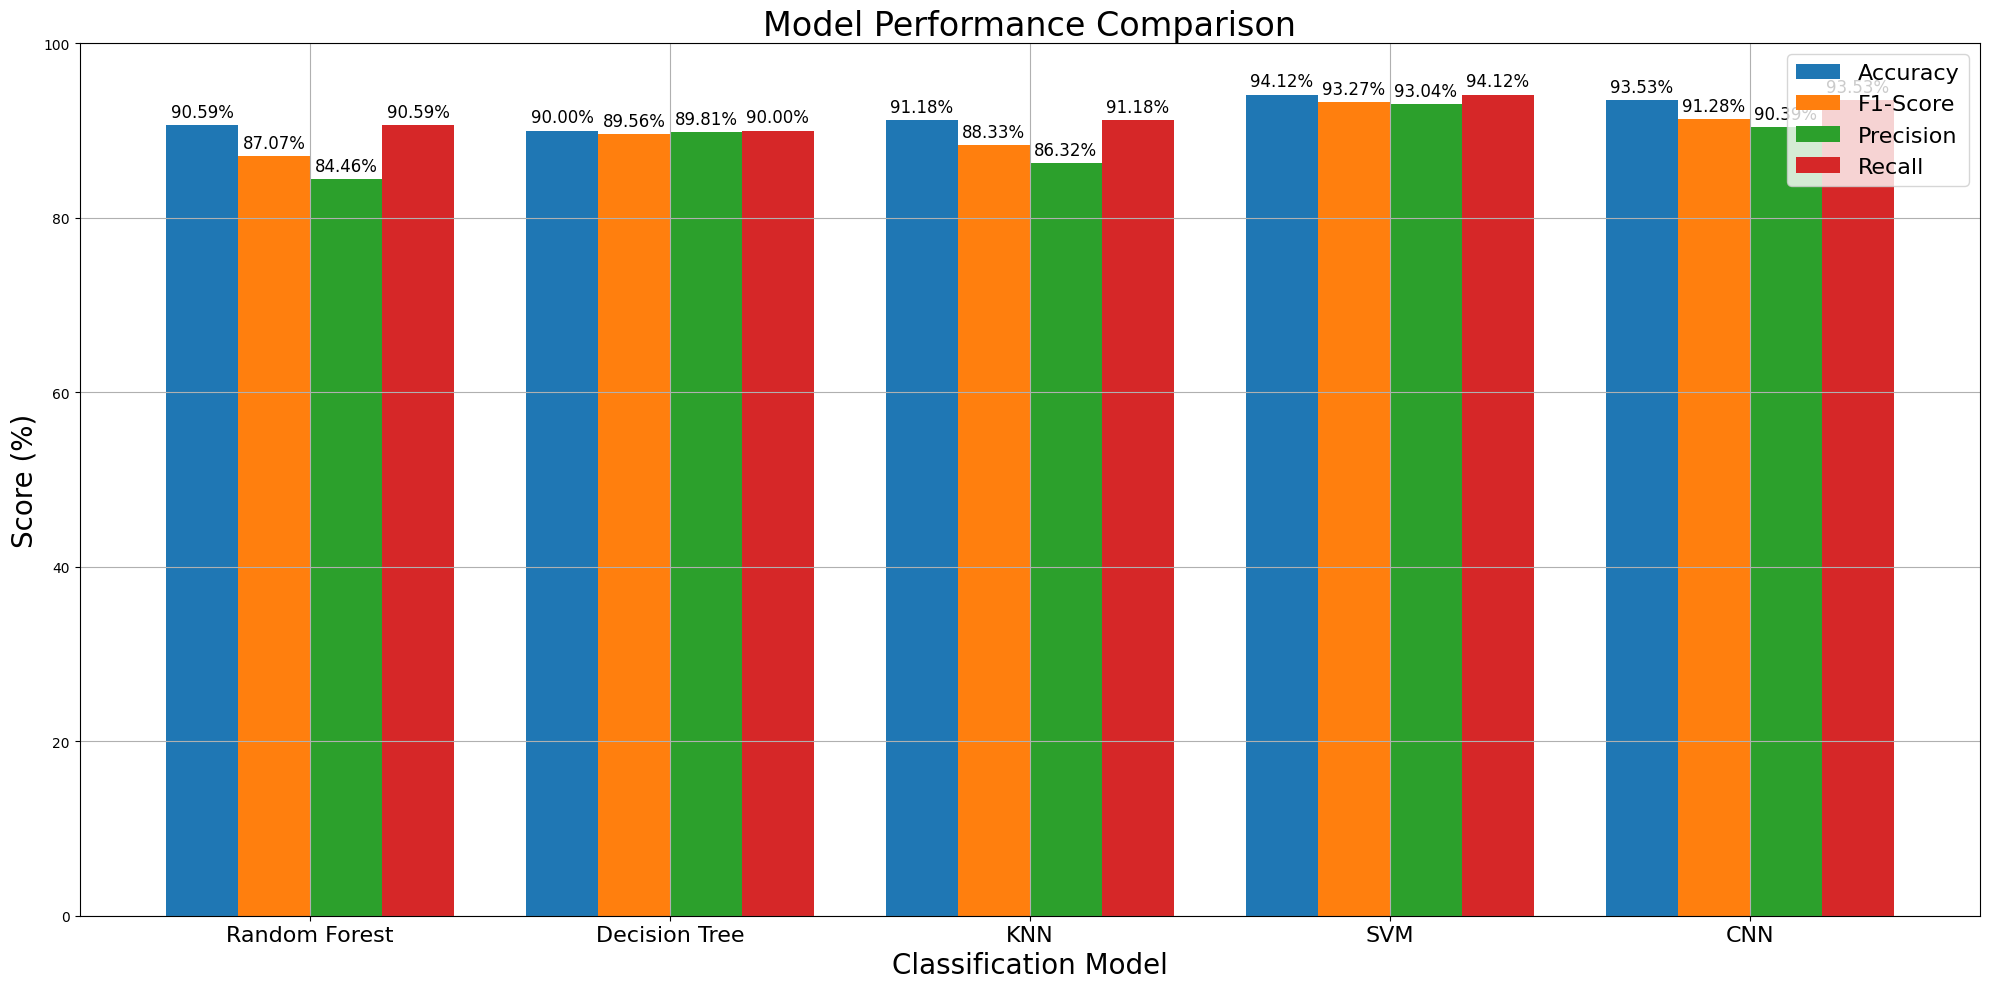

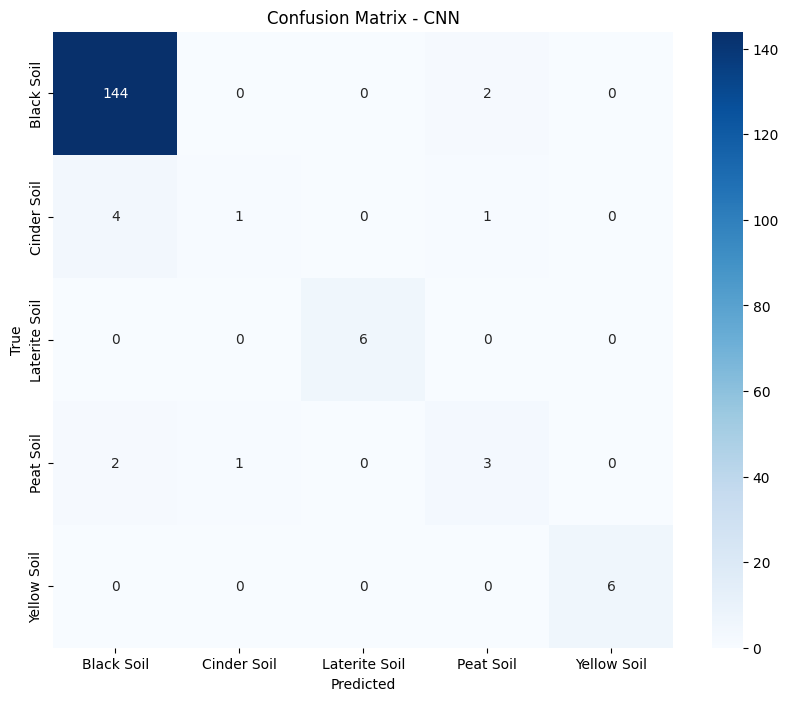

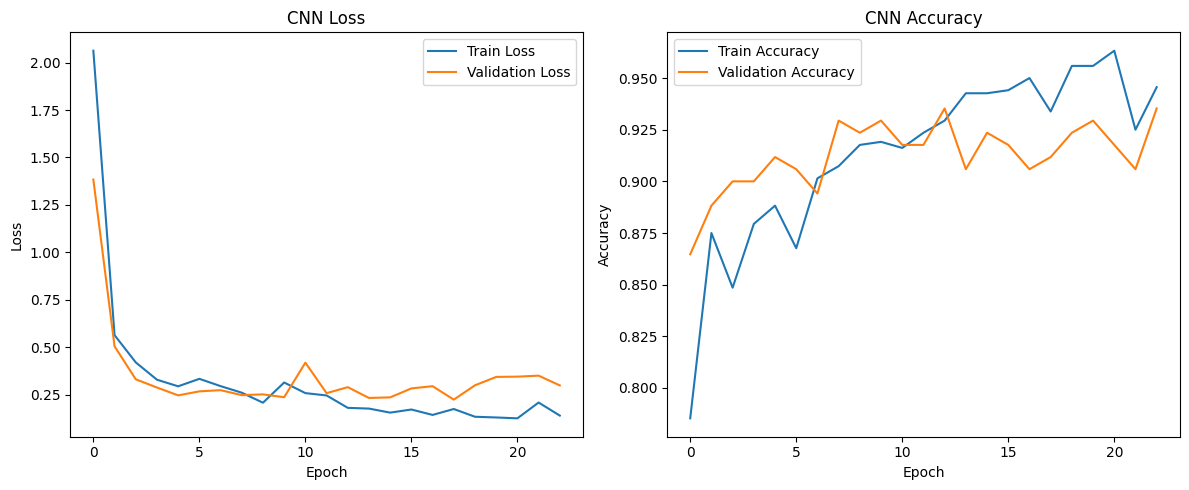

Preprocessing objects saved as 'scaler.joblib' and 'pca.joblib'

Predicted soil type for /kaggle/input/soil-types/Soil types/Laterite Soil/15.jpg: Laterite Soil


In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import cv2
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.utils import Bunch
import time
import warnings
warnings.filterwarnings("ignore")

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Define dataset paths
SOIL_TYPES_PATH = '/kaggle/input/soil-types/Soil types'
SOIL_DATA_V3_PATH = '/kaggle/input/soil-data-v3/Soil_Data_V3'

# Custom Dataset for Combined Soil Types
class SoilDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        try:
            image = Image.open(self.image_paths[idx]).convert('RGB')
            if self.transform:
                image = self.transform(image)
            label = self.labels[idx]
            return image, label
        except Exception as e:
            print(f"Error loading image {self.image_paths[idx]}: {e}")
            return None, None

# Function to load and combine datasets
def load_combined_dataset(soil_types_path, soil_data_v3_path, dimension=(128, 128)):
    image_paths = []
    labels = []
    target_names = ['Black Soil', 'Cinder Soil', 'Laterite Soil', 'Peat Soil', 'Yellow Soil']

    # Label mapping for consistency
    label_map = {
        'Black Soil': 0, 'Cinder Soil': 1, 'Laterite Soil': 2, 'Peat Soil': 3, 'Yellow Soil': 4,
        'Black': 0, 'Cinder': 1, 'Laterite': 2, 'Peat': 3, 'Yellow': 4
    }

    # Debug: Print available directories
    print(f"Checking Soil Types dataset: {soil_types_path}")
    if os.path.exists(soil_types_path):
        print(f"Contents: {os.listdir(soil_types_path)}")
    else:
        print(f"Directory not found: {soil_types_path}")

    print(f"Checking Soil_Data_V3 dataset: {soil_data_v3_path}")
    if os.path.exists(soil_data_v3_path):
        print(f"Contents: {os.listdir(soil_data_v3_path)}")
    else:
        print(f"Directory not found: {soil_data_v3_path}")

    # Load Soil Types dataset
    soil_types_dir = Path(soil_types_path)
    if soil_types_dir.exists():
        for folder in soil_types_dir.iterdir():
            if folder.is_dir() and folder.name in label_map:
                label = label_map[folder.name]
                for file in folder.iterdir():
                    if file.suffix.lower() in ['.jpg', '.jpeg', '.png', '.webp', '.gif']:
                        image_paths.append(str(file))
                        labels.append(label)

    # Load Soil_Data_V3 dataset (dynamically handle folder structure)
    soil_data_v3_dir = Path(soil_data_v3_path)
    if soil_data_v3_dir.exists():
        # Check for Train/Test subfolders, else load directly
        subfolders = [f for f in soil_data_v3_dir.iterdir() if f.is_dir()]
        if any(f.name in ['Trains', 'Tests'] for f in subfolders):
            for subfolder in ['Trains', 'Tests']:
                subfolder_path = soil_data_v3_dir / subfolder
                if subfolder_path.exists():
                    for folder in subfolder_path.iterdir():
                        if folder.is_dir() and folder.name in label_map:
                            label = label_map[folder.name]
                            for file in folder.iterdir():
                                if file.suffix.lower() in ['.jpg', '.jpeg', '.png', '.webp', '.gif']:
                                    image_paths.append(str(file))
                                    labels.append(label)
        else:
            # Load directly from class folders if no Trains/Tests
            for folder in soil_data_v3_dir.iterdir():
                if folder.is_dir() and folder.name in label_map:
                    label = label_map[folder.name]
                    for file in folder.iterdir():
                        if file.suffix.lower() in ['.jpg', '.jpeg', '.png', '.webp', '.gif']:
                            image_paths.append(str(file))
                            labels.append(label)

    # Load images for traditional ML
    flat_data = []
    images = []
    valid_paths = []
    valid_labels = []
    for path, label in zip(image_paths, labels):
        img = cv2.imread(path, cv2.IMREAD_COLOR)
        if img is None:
            print(f"Failed to read image: {path}")
            continue
        img_resized = cv2.resize(img, dimension, interpolation=cv2.INTER_AREA)
        if img_resized.size == 0:
            print(f"Empty image: {path}")
            continue
        flat_data.append(img_resized.flatten())
        images.append(img_resized)
        valid_paths.append(path)
        valid_labels.append(label)

    flat_data = np.array(flat_data)
    labels = np.array(valid_labels)
    images = np.array(images)

    return Bunch(
        data=flat_data,
        target=labels,
        target_names=target_names,
        images=images,
        image_paths=valid_paths,
        DESCR="Combined Soil Types and Soil_Data_V3 dataset"
    )

# Load combined dataset
try:
    dataset = load_combined_dataset(SOIL_TYPES_PATH, SOIL_DATA_V3_PATH)
    print(f"Combined Dataset: {len(dataset.image_paths)} images, {len(dataset.target_names)} classes")
except Exception as e:
    print(f"Error loading dataset: {e}")
    raise

# Define transforms for CNN
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Split dataset for CNN
train_paths, test_paths, train_labels, test_labels = train_test_split(
    dataset.image_paths, dataset.target, test_size=0.2, stratify=dataset.target, random_state=42
)

train_dataset = SoilDataset(train_paths, train_labels, transform=transform)
test_dataset = SoilDataset(test_paths, test_labels, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# Improved CNN Model
class SoilCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(SoilCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(64 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 64 * 16 * 16)
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# Initialize and train CNN
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SoilCNN(num_classes=5).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

# Training loop with early stopping
num_epochs = 30
best_val_acc = 0
patience = 10
patience_counter = 0
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0
    for images, labels in train_loader:
        if images is None:
            continue
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_acc = train_correct / train_total if train_total > 0 else 0
    train_loss = train_loss / len(train_loader) if len(train_loader) > 0 else 0

    # Validation
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            if images is None:
                continue
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_acc = val_correct / val_total if val_total > 0 else 0
    val_loss = val_loss / len(test_loader) if len(test_loader) > 0 else 0
    scheduler.step(val_loss)

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

    # Early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_soil_cnn.pth')
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

# Load best model
model.load_state_dict(torch.load('best_soil_cnn.pth'))
model.eval()

# Evaluate CNN
y_true = []
y_pred = []
with torch.no_grad():
    for images, labels in test_loader:
        if images is None:
            continue
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

cnn_accuracy = accuracy_score(y_true, y_pred) * 100
cnn_f1 = f1_score(y_true, y_pred, average='weighted') * 100
cnn_precision = precision_score(y_true, y_pred, average='weighted') * 100
cnn_recall = recall_score(y_true, y_pred, average='weighted') * 100
print("\nCNN Classification Report:")
print(classification_report(y_true, y_pred, target_names=dataset.target_names))

# Traditional ML Models with PCA
X_train, X_test, y_train, y_test = train_test_split(
    dataset.data, dataset.target, test_size=0.2, stratify=dataset.target, random_state=42
)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=200)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Train and evaluate ML models
models = {
    'Random Forest': RandomForestClassifier(class_weight='balanced', max_depth=9, min_samples_leaf=3, min_samples_split=2, random_state=42),
    'Decision Tree': DecisionTreeClassifier(class_weight='balanced', max_depth=9, min_samples_leaf=1, min_samples_split=2, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=7),
    'SVM': SVC(class_weight='balanced', C=10, gamma='scale', kernel='linear', random_state=42)
}

results = {'Accuracy': [], 'F1-Score': [], 'Precision': [], 'Recall': []}
for name, clf in models.items():
    start_time = time.time()
    clf.fit(X_train_pca, y_train)
    y_pred = clf.predict(X_test_pca)
    results['Accuracy'].append(round(accuracy_score(y_test, y_pred) * 100, 2))
    results['F1-Score'].append(round(f1_score(y_test, y_pred, average='weighted') * 100, 2))
    results['Precision'].append(round(precision_score(y_test, y_pred, average='weighted') * 100, 2))
    results['Recall'].append(round(recall_score(y_test, y_pred, average='weighted') * 100, 2))
    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred, target_names=dataset.target_names))
    print(f"Elapsed Time: {time.time() - start_time:.2f} seconds")

# Add CNN results
results['Accuracy'].append(round(cnn_accuracy, 2))
results['F1-Score'].append(round(cnn_f1, 2))
results['Precision'].append(round(cnn_precision, 2))
results['Recall'].append(round(cnn_recall, 2))

# Print Accuracy and Related Metrics for All Models
print("\n=== Model Performance Summary ===")
print(f"{'Model':<15} {'Accuracy (%)':<12} {'F1-Score (%)':<12} {'Precision (%)':<13} {'Recall (%)':<12}")
print("-" * 65)
for i, model_name in enumerate(list(models.keys()) + ['CNN']):
    print(f"{model_name:<15} {results['Accuracy'][i]:<12.2f} {results['F1-Score'][i]:<12.2f} {results['Precision'][i]:<13.2f} {results['Recall'][i]:<12.2f}")

# Visualize Results
labels = list(models.keys()) + ['CNN']
fig, ax = plt.subplots(figsize=(20, 10))
bar_width = 0.2
index = range(len(labels))

for i, metric in enumerate(results.keys()):
    ax.bar([x + i * bar_width for x in index], results[metric], bar_width, label=metric)

for i, metric in enumerate(results.keys()):
    for j, value in enumerate(results[metric]):
        ax.annotate(f'{value:.2f}%', xy=(j + i * bar_width, value), xytext=(0, 3),
                    textcoords="offset points", ha='center', va='bottom', fontsize=12)

plt.xlabel("Classification Model", fontsize=20)
plt.ylabel("Score (%)", fontsize=20)
plt.title("Model Performance Comparison", fontsize=24)
plt.xticks([i + bar_width * 1.5 for i in index], labels, fontsize=16)
plt.legend(fontsize=16)
plt.ylim(0, 100)
plt.grid(True)
plt.tight_layout()
plt.show()

# Confusion Matrix for CNN
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.target_names, yticklabels=dataset.target_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - CNN')
plt.show()

# Plot Training History
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('CNN Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('CNN Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

# Save preprocessing objects
import joblib
joblib.dump(scaler, 'scaler.joblib')
joblib.dump(pca, 'pca.joblib')
print("Preprocessing objects saved as 'scaler.joblib' and 'pca.joblib'")

# Function to predict soil type for a single image
def predict_soil_type(image_path, model, transform, device, target_names):
    try:
        image = Image.open(image_path).convert('RGB')
        image = transform(image).unsqueeze(0).to(device)
        model.eval()
        with torch.no_grad():
            output = model(image)
            _, predicted = torch.max(output, 1)
        return target_names[predicted.item()]
    except Exception as e:
        print(f"Error predicting for {image_path}: {e}")
        return None

# Test single image prediction
image_path = '/kaggle/input/soil-types/Soil types/Laterite Soil/15.jpg'
predicted_soil = predict_soil_type(image_path, model, transform, device, dataset.target_names)
print(f"\nPredicted soil type for {image_path}: {predicted_soil}")

Directory contents of /kaggle/input/soil-dataset-test: ['soil-2.png', 'soil.jpeg']

Attempting to display image: /kaggle/input/soil-dataset-test/soil-2.png
File size: 657172 bytes
File permissions: 644
File extension: .png
Successfully opened /kaggle/input/soil-dataset-test/soil-2.png. Image mode: RGB, size: (657, 635)


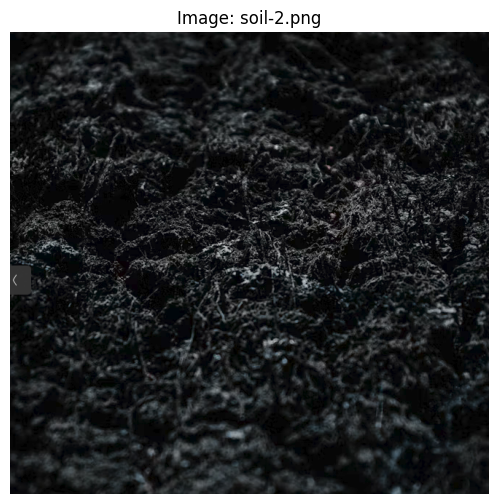


Predicting soil type for: /kaggle/input/soil-dataset-test/soil-2.png
Predicted soil type for /kaggle/input/soil-dataset-test/soil-2.png: Black Soil


In [2]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torchvision import transforms

def display_image(image_path):
    try:
        if not os.path.exists(image_path):
            print(f"File does not exist: {image_path}")
            return False
        
        valid_extensions = ['.jpg', '.jpeg', '.png', '.webp', '.gif']
        if not any(image_path.lower().endswith(ext) for ext in valid_extensions):
            print(f"Unsupported file extension for {image_path}. Supported: {valid_extensions}")
            return False

        image = Image.open(image_path).convert('RGB')
        print(f"Successfully opened {image_path}. Image mode: {image.mode}, size: {image.size}")
        plt.figure(figsize=(8, 6))
        plt.imshow(image)
        plt.axis('off')
        plt.title(f"Image: {os.path.basename(image_path)}")
        plt.show()
        return True
    except Exception as e:
        print(f"Error displaying {image_path}: {str(e)}")
        return False

def predict_soil_type(image_path, model, transform, device, target_names):
    try:
        if not os.path.exists(image_path):
            print(f"File does not exist: {image_path}")
            return None
        
        valid_extensions = ['.jpg', '.jpeg', '.png', '.webp', '.gif']
        if not any(image_path.lower().endswith(ext) for ext in valid_extensions):
            print(f"Unsupported file extension for {image_path}. Supported: {valid_extensions}")
            return None

        image = Image.open(image_path).convert('RGB')
        image = transform(image).unsqueeze(0).to(device)
        model.eval()
        with torch.no_grad():
            output = model(image)
            _, predicted = torch.max(output, 1)
        return target_names[predicted.item()]
    except Exception as e:
        print(f"Error predicting for {image_path}: {str(e)}")
        return None

# Define transform, device, and target names (from your original code)
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
target_names = ['Black Soil', 'Cinder Soil', 'Laterite Soil', 'Peat Soil', 'Yellow Soil']

# Assuming 'model' is already defined and loaded from your original code (best_soil_cnn.pth)
# If not, ensure you load it:
# model = SoilCNN(num_classes=5).to(device)
# model.load_state_dict(torch.load('best_soil_cnn.pth'))
# model.eval()

# Define the target directory and image
dataset_dir = '/kaggle/input/soil-dataset-test'
test_image = os.path.join(dataset_dir, 'soil-2.png')  # Use the valid image

# Display directory contents
print(f"Directory contents of {dataset_dir}: {os.listdir(dataset_dir)}")

# Display the image
print(f"\nAttempting to display image: {test_image}")
if os.path.exists(test_image):
    print(f"File size: {os.path.getsize(test_image)} bytes")
    print(f"File permissions: {oct(os.stat(test_image).st_mode)[-3:]}")
    print(f"File extension: {os.path.splitext(test_image)[1].lower()}")
    success = display_image(test_image)
else:
    print(f"File not found: {test_image}")
    success = False

# Predict soil type if display is successful
if success:
    print(f"\nPredicting soil type for: {test_image}")
    predicted_soil = predict_soil_type(test_image, model, transform, device, target_names)
    print(f"Predicted soil type for {test_image}: {predicted_soil}")
else:
    print(f"\nNo valid image to predict soil type.")

# If the image fails, try another from the same folder
if not success:
    valid_images = [f for f in os.listdir(dataset_dir) if any(f.lower().endswith(ext) for ext in ['.jpg', '.jpeg', '.png', '.webp', '.gif']) and f != 'soil.jpeg']
    if valid_images:
        fallback_image = os.path.join(dataset_dir, valid_images[0])
        print(f"\nAttempting to display and predict fallback image: {fallback_image}")
        if os.path.exists(fallback_image):
            print(f"File size: {os.path.getsize(fallback_image)} bytes")
            print(f"File permissions: {oct(os.stat(fallback_image).st_mode)[-3:]}")
            print(f"File extension: {os.path.splitext(fallback_image)[1].lower()}")
            success = display_image(fallback_image)
            if success:
                print(f"\nPredicting soil type for: {fallback_image}")
                predicted_soil = predict_soil_type(fallback_image, model, transform, device, target_names)
                print(f"Predicted soil type for {fallback_image}: {predicted_soil}")
    else:
        print(f"No other valid images found in {dataset_dir}")


Exploring directory: /kaggle/input/soil-dataset-testing
Directory contents: ['WhatsApp Image 2025-08-29 at 2.30.25 PM.jpeg', 'soil-2.png', 'Soil_Auroville.JPG', 'yellow.webp', 'cinder-1.jpg', 'soil.jpeg']

Found 6 valid image(s): ['WhatsApp Image 2025-08-29 at 2.30.25 PM.jpeg', 'soil-2.png', 'Soil_Auroville.JPG', 'yellow.webp', 'cinder-1.jpg', 'soil.jpeg']

Processing image: /kaggle/input/soil-dataset-testing/WhatsApp Image 2025-08-29 at 2.30.25 PM.jpeg
File size: 149952 bytes
File permissions: 644
File extension: .jpeg
Successfully opened /kaggle/input/soil-dataset-testing/WhatsApp Image 2025-08-29 at 2.30.25 PM.jpeg. Image mode: RGB, size: (702, 1600)


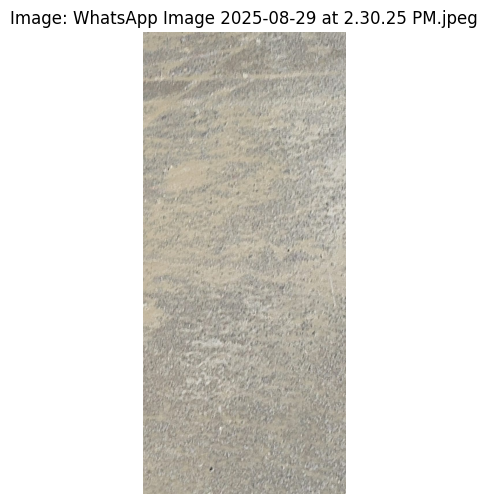

Predicting soil type for: /kaggle/input/soil-dataset-testing/WhatsApp Image 2025-08-29 at 2.30.25 PM.jpeg
Predicted soil type for /kaggle/input/soil-dataset-testing/WhatsApp Image 2025-08-29 at 2.30.25 PM.jpeg: Peat Soil

Processing image: /kaggle/input/soil-dataset-testing/soil-2.png
File size: 657172 bytes
File permissions: 644
File extension: .png
Successfully opened /kaggle/input/soil-dataset-testing/soil-2.png. Image mode: RGB, size: (657, 635)


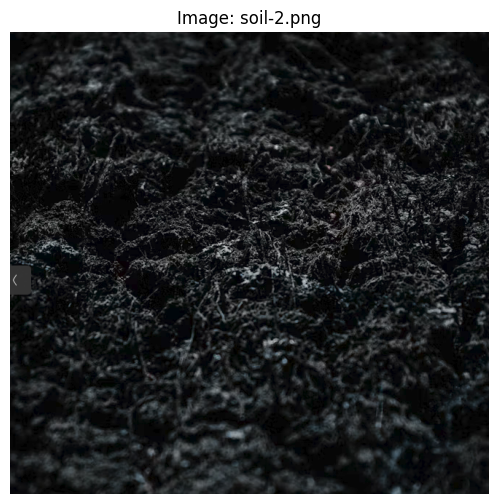

Predicting soil type for: /kaggle/input/soil-dataset-testing/soil-2.png
Predicted soil type for /kaggle/input/soil-dataset-testing/soil-2.png: Black Soil

Processing image: /kaggle/input/soil-dataset-testing/Soil_Auroville.JPG
File size: 487753 bytes
File permissions: 644
File extension: .jpg
Successfully opened /kaggle/input/soil-dataset-testing/Soil_Auroville.JPG. Image mode: RGB, size: (1200, 800)


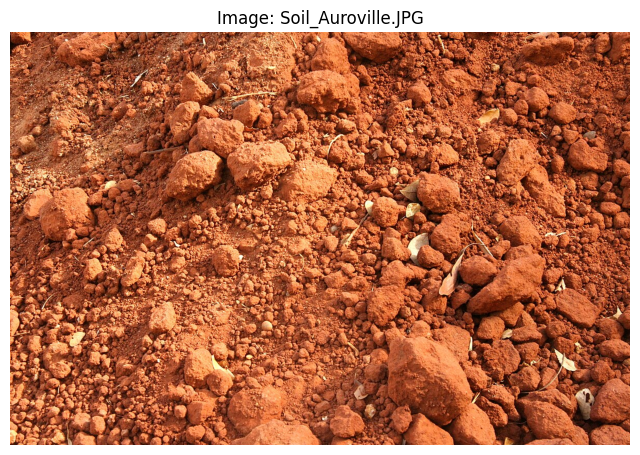

Predicting soil type for: /kaggle/input/soil-dataset-testing/Soil_Auroville.JPG
Predicted soil type for /kaggle/input/soil-dataset-testing/Soil_Auroville.JPG: Laterite Soil

Processing image: /kaggle/input/soil-dataset-testing/yellow.webp
File size: 158950 bytes
File permissions: 644
File extension: .webp
Successfully opened /kaggle/input/soil-dataset-testing/yellow.webp. Image mode: RGB, size: (700, 462)


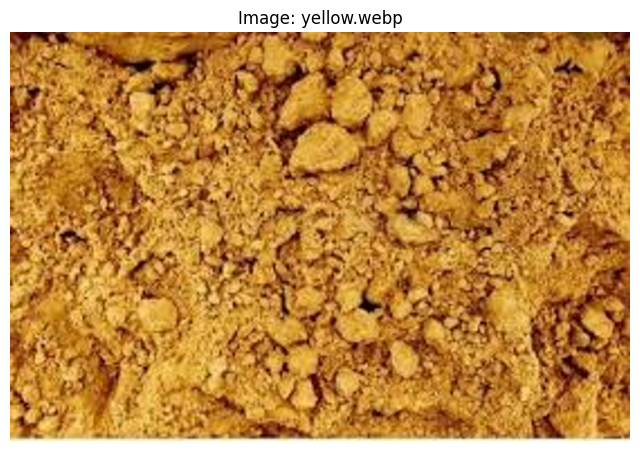

Predicting soil type for: /kaggle/input/soil-dataset-testing/yellow.webp
Predicted soil type for /kaggle/input/soil-dataset-testing/yellow.webp: Yellow Soil

Processing image: /kaggle/input/soil-dataset-testing/cinder-1.jpg
File size: 348950 bytes
File permissions: 644
File extension: .jpg
Successfully opened /kaggle/input/soil-dataset-testing/cinder-1.jpg. Image mode: RGB, size: (1024, 1024)


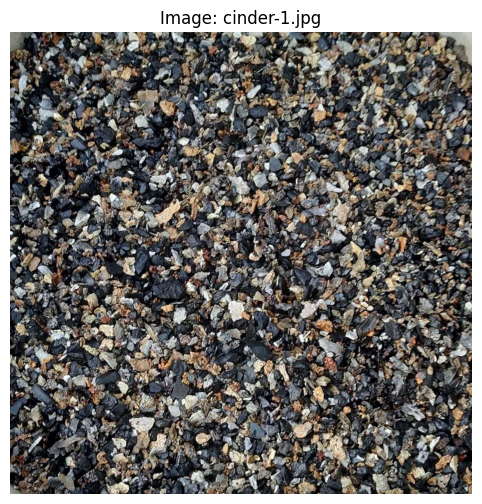

Predicting soil type for: /kaggle/input/soil-dataset-testing/cinder-1.jpg
Predicted soil type for /kaggle/input/soil-dataset-testing/cinder-1.jpg: Black Soil

Processing image: /kaggle/input/soil-dataset-testing/soil.jpeg
File size: 94717 bytes
File permissions: 644
File extension: .jpeg
Error displaying /kaggle/input/soil-dataset-testing/soil.jpeg: cannot identify image file '/kaggle/input/soil-dataset-testing/soil.jpeg'
Skipping prediction for /kaggle/input/soil-dataset-testing/soil.jpeg due to display failure.


In [3]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torchvision import transforms

def display_image(image_path):
    try:
        if not os.path.exists(image_path):
            print(f"File does not exist: {image_path}")
            return False
        
        valid_extensions = ['.jpg', '.jpeg', '.png', '.webp', '.gif']
        if not any(image_path.lower().endswith(ext) for ext in valid_extensions):
            print(f"Unsupported file extension for {image_path}. Supported: {valid_extensions}")
            return False

        image = Image.open(image_path).convert('RGB')
        print(f"Successfully opened {image_path}. Image mode: {image.mode}, size: {image.size}")
        plt.figure(figsize=(8, 6))
        plt.imshow(image)
        plt.axis('off')
        plt.title(f"Image: {os.path.basename(image_path)}")
        plt.show()
        return True
    except Exception as e:
        print(f"Error displaying {image_path}: {str(e)}")
        return False

def predict_soil_type(image_path, model, transform, device, target_names):
    try:
        if not os.path.exists(image_path):
            print(f"File does not exist: {image_path}")
            return None
        
        valid_extensions = ['.jpg', '.jpeg', '.png', '.webp', '.gif']
        if not any(image_path.lower().endswith(ext) for ext in valid_extensions):
            print(f"Unsupported file extension for {image_path}. Supported: {valid_extensions}")
            return None

        image = Image.open(image_path).convert('RGB')
        image = transform(image).unsqueeze(0).to(device)
        model.eval()
        with torch.no_grad():
            output = model(image)
            _, predicted = torch.max(output, 1)
        return target_names[predicted.item()]
    except Exception as e:
        print(f"Error predicting for {image_path}: {str(e)}")
        return None

# Define transform, device, and target names (from your original code)
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
target_names = ['Black Soil', 'Cinder Soil', 'Laterite Soil', 'Peat Soil', 'Yellow Soil']

# Assuming 'model' is already defined and loaded from your original code (best_soil_cnn.pth)
# If not, ensure you load it:
# model = SoilCNN(num_classes=5).to(device)
# model.load_state_dict(torch.load('best_soil_cnn.pth'))
# model.eval()

# Define the target directory
dataset_dir = '/kaggle/input/soil-dataset-testing'

# Get all files in the directory
print(f"\nExploring directory: {dataset_dir}")
all_files = os.listdir(dataset_dir)
print(f"Directory contents: {all_files}")

# Filter for valid image files
valid_extensions = ['.jpg', '.jpeg', '.png', '.webp', '.gif']
image_files = [f for f in all_files if any(f.lower().endswith(ext) for ext in valid_extensions)]

if not image_files:
    print(f"No valid images found in {dataset_dir}")
else:
    print(f"\nFound {len(image_files)} valid image(s): {image_files}")
    for image_file in image_files:
        image_path = os.path.join(dataset_dir, image_file)
        print(f"\nProcessing image: {image_path}")
        print(f"File size: {os.path.getsize(image_path)} bytes")
        print(f"File permissions: {oct(os.stat(image_path).st_mode)[-3:]}")
        print(f"File extension: {os.path.splitext(image_path)[1].lower()}")

        # Display the image
        success = display_image(image_path)

        # Predict soil type if display is successful
        if success:
            print(f"Predicting soil type for: {image_path}")
            predicted_soil = predict_soil_type(image_path, model, transform, device, target_names)
            print(f"Predicted soil type for {image_path}: {predicted_soil}")
        else:
            print(f"Skipping prediction for {image_path} due to display failure.")